In [1]:
from data_augmentor import data_augment, batchify
from time_expector import TimeExpector
from notify import notify
from sys import stdout

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

from time import sleep
from sklearn.model_selection import train_test_split

In [2]:
dtype = torch.float
tx = TimeExpector()

# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")

using cpu...


In [3]:
CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached/"
DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture/"
    
nb_image_height = 64
nb_image_weight = 64
nb_inputs  = nb_image_height*nb_image_weight
nb_hidden  = 64
nb_outputs = 12

time_step = 1e-3
nb_steps  = 100

batch_size = 32

In [4]:
def load_data(trail):
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation
    )

In [5]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [6]:
def init_network():
    global w1, w2, loss_histogram_train, loss_histogram_test
    weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

    w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

    w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

    
    loss_histogram_train = []
    loss_histogram_test = []
    print('init')

In [7]:
class SuperSpike(torch.autograd.Function):
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SuperSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
spike_fn  = SuperSpike.apply

In [8]:
def run_snn(inputs):
#     print inputs.shape, 'vs', w1.shape
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]

        new_syn = alpha*syn +h1[:,t]
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [9]:
def prog_print(items, max_items):
    percentage = 100*items/max_items
    items = int(items)
    max_items = int(max_items)
    
    stdout.write('\r')
    stdout.write('  %.2f%%' % percentage)
    stdout.write('  [=')
    if items < max_items:
        stdout.write('=' * (items-1))
        stdout.write('>')
        stdout.write('.' * (max_items - items))
    else:
        stdout.write('=' * (items))
    stdout.write(']  ')
    stdout.flush()

In [10]:
def train_on_one_batch(x_local, y_local, apply_optimization, params, optimizer, log_softmax_fn, loss_fn):
    x_local = np.reshape(x_local, (batch_size, nb_steps, 64*64))
    x_local = torch.from_numpy(x_local).type(dtype)
    y_local = torch.from_numpy(y_local.astype(np.long))

    output,_ = run_snn(x_local)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_local)

    if apply_optimization:
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
    return loss_val.item()
    

def train(learning_rate, nb_epochs):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=learning_rate, betas=(0.9,0.999))
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    for e in range(nb_epochs):
        tx.tick(nb_epochs - e)
        local_loss_train = []
        local_loss_test = []
        print 'Epoch %d/%d' % (e+1,nb_epochs)
        
        pc = 0
        for x_local, y_local in load_data('train'):
            prog_print(pc, 55)
            pc += .1
            loss = train_on_one_batch(x_local, y_local, True, params, optimizer, log_softmax_fn, loss_fn)
            local_loss_train.append(loss)
            
        for x_local, y_local in load_data('test'):
            prog_print(pc, 55)
            pc += .1
            loss = train_on_one_batch(x_local, y_local, False, params, optimizer, log_softmax_fn, loss_fn)
            local_loss_test.append(loss)
            
        mean_loss_train = np.mean(local_loss_train)
        mean_loss_test = np.mean(local_loss_test)
        print('- loss (train=%.5f , test=%.5f)' % (mean_loss_train, mean_loss_test))
        loss_histogram_train.append(mean_loss_train)
        loss_histogram_test.append(mean_loss_test)
        tx.tock()

In [11]:
def compute_classification_accuracy(trail):
    accs = []
    heatmap = np.zeros((nb_outputs, nb_outputs))
    
    for x_local, y_local in load_data('acc_%s' % trail):
        x_local = np.reshape(x_local, (batch_size, nb_steps, 64*64))
        x_local = torch.from_numpy(x_local).type(dtype)
        output, _ = run_snn(x_local)
        m, _ = torch.max(output,1)
        _, am = torch.max(m,1)
        accs.append(np.mean(y_local == am.detach().cpu().numpy() ))
        
        for i in range(y_local.shape[0]):
            heatmap[y_local[i], am[i]] += 1
    return accs, heatmap

def print_and_plot_accuracy_metrics():
    accs_train, heatmap_train = compute_classification_accuracy('train')
    accs_test, heatmap_test = compute_classification_accuracy('test')

    print("Train accuracy: %f" % (np.mean(np.array(accs_train))))
    print("Test accuracy: %f" % (np.mean(np.array(accs_test))))

    sns.heatmap(heatmap_train)
    plt.title('Train Result Heatmap (%.1f%%)' % (np.mean(np.array(accs_train))*100))
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()

    sns.heatmap(heatmap_test)
    plt.title('Test Result Heatmap (%.1f%%)' % (np.mean(np.array(accs_test))*100))
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()

In [12]:
%matplotlib inline
def plot_loss_diagrams():
    plt.figure(figsize=(3.3,2), dpi=150)
    plt.plot(loss_histogram_train, 'b', label='train')
    plt.plot(loss_histogram_test, 'r--', label='test')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    sns.despine()

def plot_voltage_traces(mem, spk=None, dim=(1,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")
    plt.show()
    
def plot_neuron_activities():
    for x_local, _ in load_data('acc_train'):
        x_local = np.reshape(x_local, (batch_size, nb_steps, 64*64))
        x_local = torch.from_numpy(x_local).type(dtype)
        output, other_recordings = run_snn(x_local)
        mem_rec, spk_rec = other_recordings
        break

    print 'mem_rec/spk_rec data'
    fig=plt.figure(dpi=100)
    plot_voltage_traces(mem_rec, spk_rec)

    print 'Output data'
    fig=plt.figure(dpi=100)
    plot_voltage_traces(output)

    print 'Spike Activity'
    nb_plt = 4
    gs = GridSpec(1,nb_plt)
    fig= plt.figure(figsize=(7,3),dpi=150)
    for i in range(nb_plt):
        plt.subplot(gs[i])
        plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
        if i==0:
            plt.xlabel("Time")
            plt.ylabel("Units")

        sns.despine()
    plt.show()

In [13]:
should_init = True

ℹ️ *Simple-SNN* has started.
init
Epoch 1/10
  101.09%  [========================================================]  - loss (train=2.38962 , test=2.32253)
[operation finished at 2020-01-27 13:38:24  -  took 4 minutes]
[expecting to finish at 2020-01-27 14:15:31]
Epoch 2/10
  101.09%  [========================================================]  .....................................................]  - loss (train=2.18241 , test=2.25449)
[operation finished at 2020-01-27 13:42:30  -  took 4 minutes]
[expecting to finish at 2020-01-27 14:15:29]
Epoch 3/10
  101.09%  [========================================================]  - loss (train=2.09152 , test=2.23249)
[operation finished at 2020-01-27 13:46:31  -  took 4 minutes]
[expecting to finish at 2020-01-27 14:15:17]
Epoch 4/10
  101.09%  [========================================================]    - loss (train=2.03505 , test=2.28488)
[operation finished at 2020-01-27 13:50:27  -  took 3 minutes]
[expecting to finish at 2020-01-27 14:15:

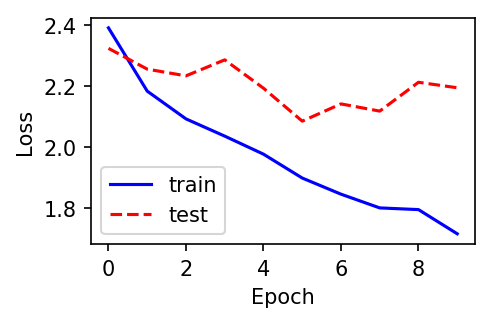

mem_rec/spk_rec data


<Figure size 432x288 with 0 Axes>

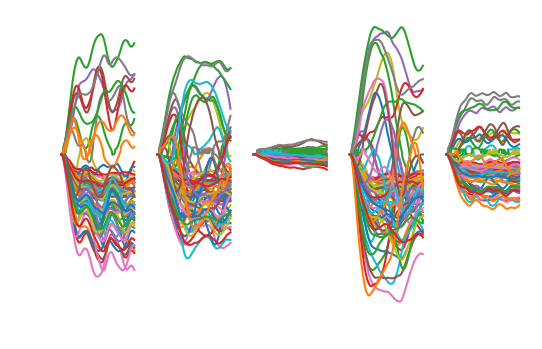

Output data


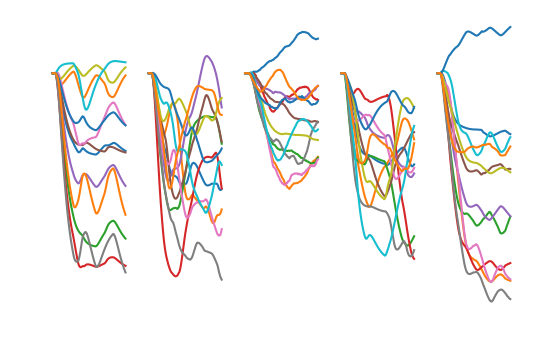

Spike Activity


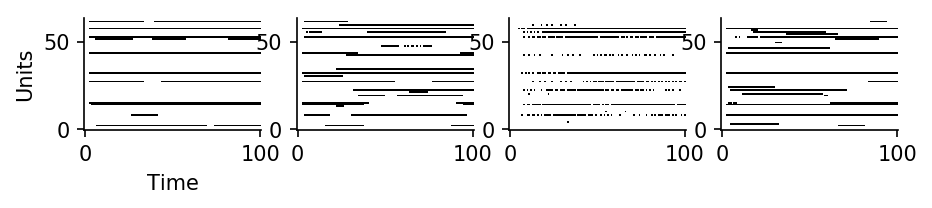

Train accuracy: 0.525943
Test accuracy: 0.375000


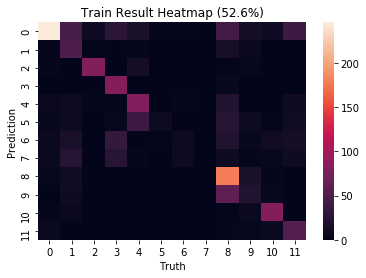

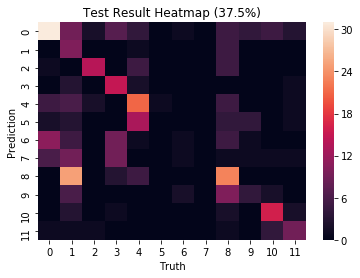

ℹ️ *Simple-SNN* Trail #0 finished.
[expecting to finish at 2020-01-27 14:56:04]
Epoch 1/10
  101.09%  [========================================================]  - loss (train=1.70247 , test=2.15926)
[operation finished at 2020-01-27 14:32:06  -  took 16 minutes]
[expecting to finish at 2020-01-27 15:20:31]
Epoch 2/10
  101.09%  [========================================================]  - loss (train=1.63130 , test=2.13039)
[operation finished at 2020-01-27 14:36:28  -  took 4 minutes]
[expecting to finish at 2020-01-27 15:18:41]
Epoch 3/10
  101.09%  [========================================================]  - loss (train=1.64896 , test=2.02289)
[operation finished at 2020-01-27 14:40:40  -  took 4 minutes]
[expecting to finish at 2020-01-27 15:16:52]
Epoch 4/10
  101.09%  [========================================================]  - loss (train=1.55131 , test=1.97858)
[operation finished at 2020-01-27 14:45:01  -  took 4 minutes]
[expecting to finish at 2020-01-27 15:15:33]
Epoch 5

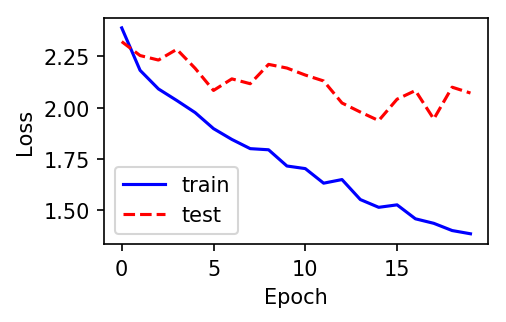

mem_rec/spk_rec data


<Figure size 432x288 with 0 Axes>

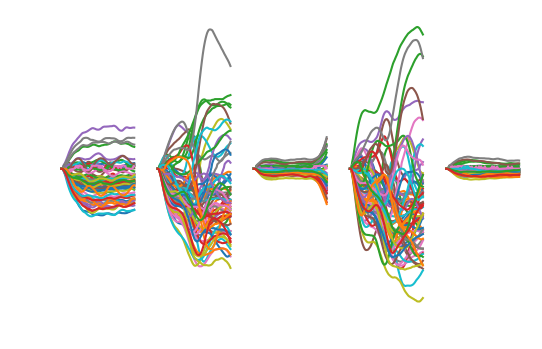

Output data


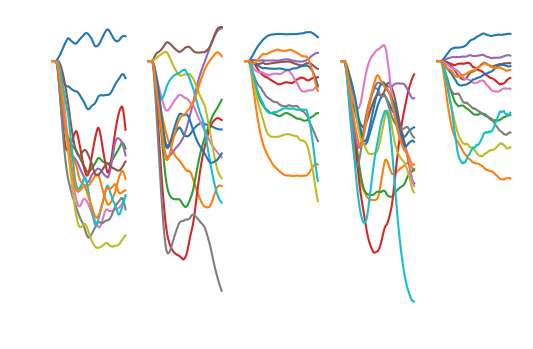

Spike Activity


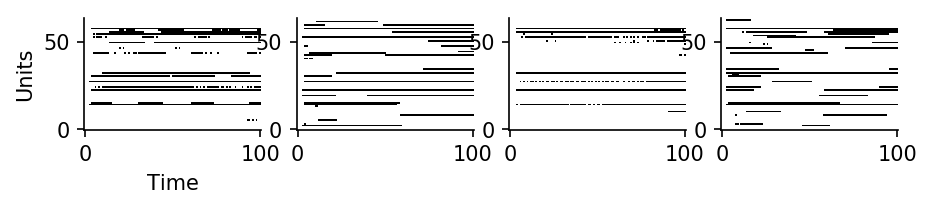

Train accuracy: 0.631486
Test accuracy: 0.445312


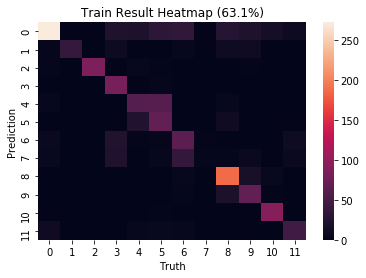

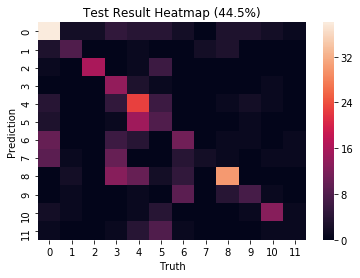

ℹ️ *Simple-SNN* Trail #1 finished.
[expecting to finish at 2020-01-27 15:57:31]
Epoch 1/10
  101.09%  [========================================================]  - loss (train=1.36447 , test=1.95182)
[operation finished at 2020-01-27 15:14:36  -  took 3 minutes]
[expecting to finish at 2020-01-27 15:56:01]
Epoch 2/10
  101.09%  [========================================================]    ========================================>..............]  - loss (train=1.35260 , test=2.04317)
[operation finished at 2020-01-27 15:18:35  -  took 3 minutes]
[expecting to finish at 2020-01-27 15:54:55]
Epoch 3/10
  101.09%  [========================================================]  - loss (train=1.33125 , test=1.89139)
[operation finished at 2020-01-27 15:22:55  -  took 4 minutes]
[expecting to finish at 2020-01-27 15:54:34]
Epoch 4/10
  101.09%  [========================================================]  - loss (train=1.25900 , test=1.97683)
[operation finished at 2020-01-27 15:27:08  -  took 4 mi

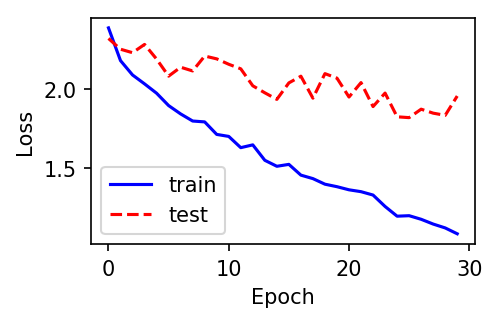

mem_rec/spk_rec data


<Figure size 432x288 with 0 Axes>

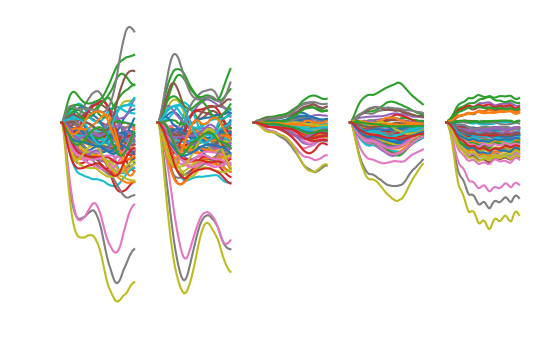

Output data


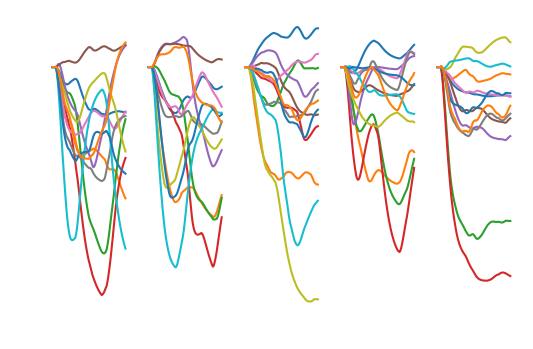

Spike Activity


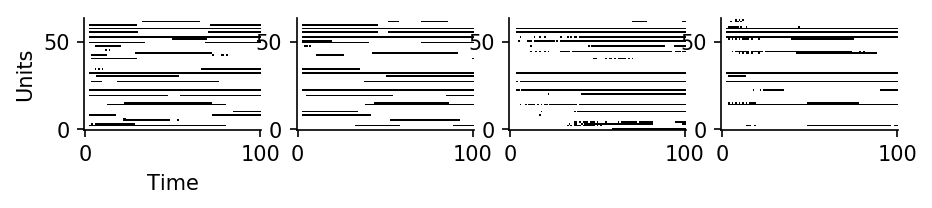

Train accuracy: 0.704009
Test accuracy: 0.518229


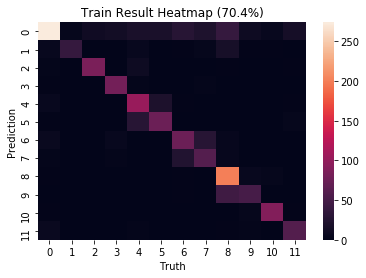

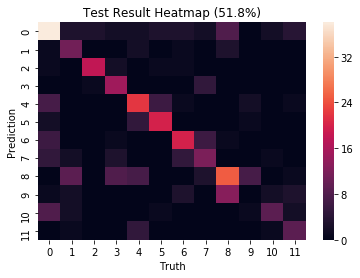

ℹ️ *Simple-SNN* Trail #2 finished.
[expecting to finish at 2020-01-27 16:39:05]
Epoch 1/10
  101.09%  [========================================================]  - loss (train=1.06824 , test=2.08280)
[operation finished at 2020-01-27 15:58:51  -  took 4 minutes]
[expecting to finish at 2020-01-27 16:39:22]
Epoch 2/10
  101.09%  [========================================================]  - loss (train=1.07110 , test=1.85199)
[operation finished at 2020-01-27 16:03:22  -  took 4 minutes]
[expecting to finish at 2020-01-27 16:39:23]
Epoch 3/10
  101.09%  [========================================================]  ................................................]  - loss (train=1.07767 , test=1.93267)
[operation finished at 2020-01-27 16:07:48  -  took 4 minutes]
[expecting to finish at 2020-01-27 16:39:16]
Epoch 4/10
  101.09%  [========================================================]  .]  - loss (train=1.08905 , test=1.80306)
[operation finished at 2020-01-27 16:12:15  -  took 4 minutes

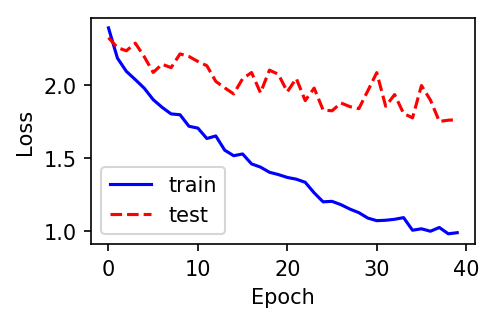

mem_rec/spk_rec data


<Figure size 432x288 with 0 Axes>

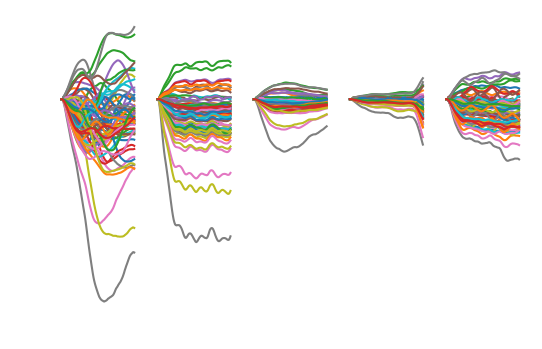

Output data


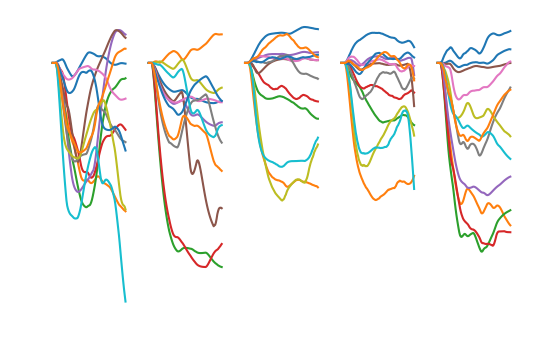

Spike Activity


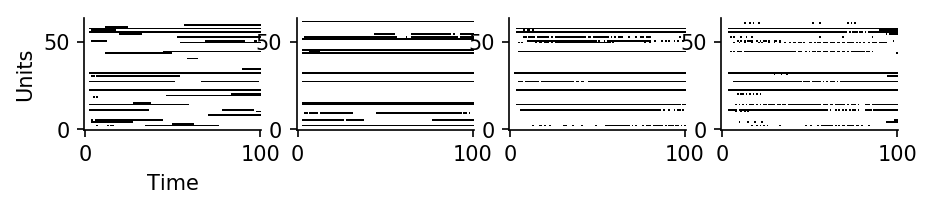

Train accuracy: 0.784198
Test accuracy: 0.557292


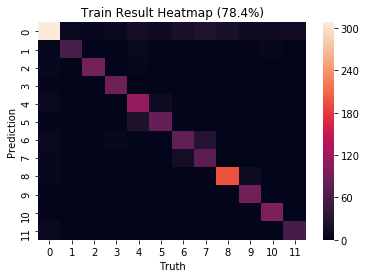

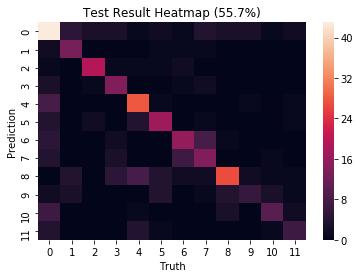

ℹ️ *Simple-SNN* Trail #3 finished.
[expecting to finish at 2020-01-27 17:24:04]
Epoch 1/10
  101.09%  [========================================================]  ====================================================>.]  - loss (train=0.98277 , test=1.98216)
[operation finished at 2020-01-27 16:43:57  -  took 4 minutes]
[expecting to finish at 2020-01-27 17:24:23]
Epoch 2/10
  101.09%  [========================================================]  - loss (train=0.96457 , test=1.83146)
[operation finished at 2020-01-27 16:48:19  -  took 4 minutes]
[expecting to finish at 2020-01-27 17:24:10]
Epoch 3/10
  101.09%  [========================================================]  - loss (train=0.97694 , test=1.79904)
[operation finished at 2020-01-27 16:52:39  -  took 4 minutes]
[expecting to finish at 2020-01-27 17:23:54]
Epoch 4/10
  101.09%  [========================================================]  - loss (train=0.92888 , test=1.62974)
[operation finished at 2020-01-27 16:57:15  -  took 4 minut

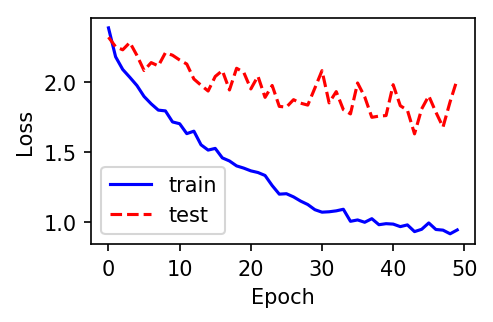

mem_rec/spk_rec data


<Figure size 432x288 with 0 Axes>

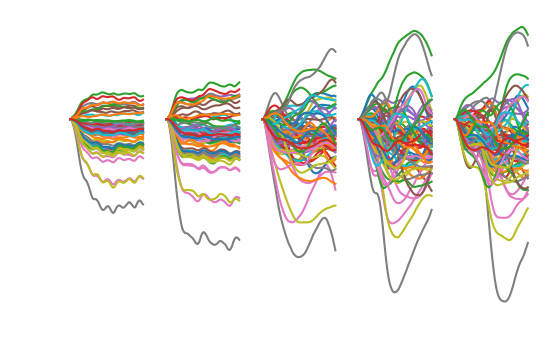

Output data


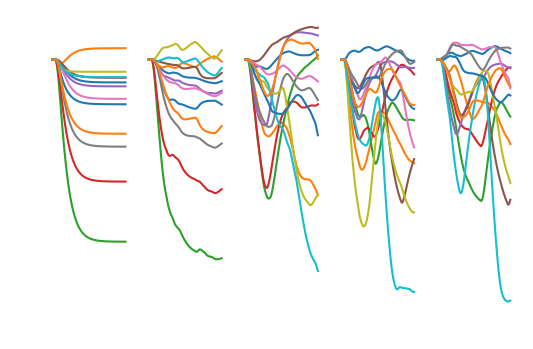

Spike Activity


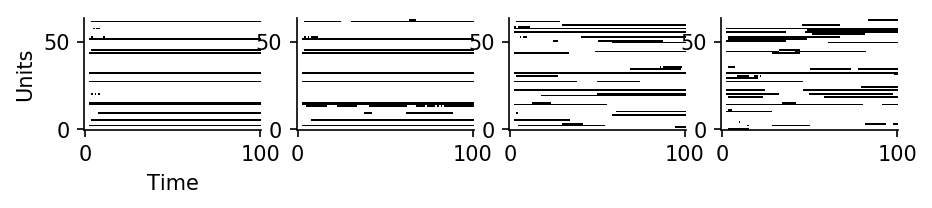

Train accuracy: 0.764151
Test accuracy: 0.523438


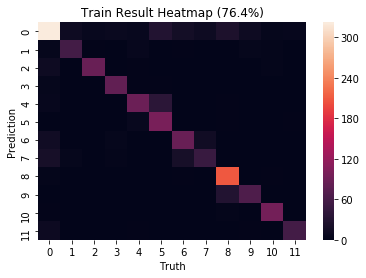

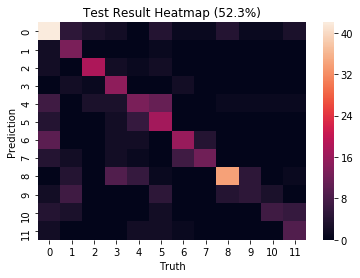

ℹ️ *Simple-SNN* Trail #4 finished.
[expecting to finish at 2020-01-27 18:09:17]
Epoch 1/10
  101.09%  [========================================================]  - loss (train=0.93675 , test=1.83543)
[operation finished at 2020-01-27 17:28:48  -  took 4 minutes]
[expecting to finish at 2020-01-27 18:09:05]
Epoch 2/10
  101.09%  [========================================================]  - loss (train=0.94931 , test=1.85686)
[operation finished at 2020-01-27 17:33:28  -  took 4 minutes]
[expecting to finish at 2020-01-27 18:09:26]
Epoch 3/10
  101.09%  [========================================================]  - loss (train=0.91416 , test=1.69479)
[operation finished at 2020-01-27 17:37:58  -  took 4 minutes]
[expecting to finish at 2020-01-27 18:09:27]
Epoch 4/10
  101.09%  [========================================================]  ====================================>.................]  - loss (train=0.95815 , test=1.84999)
[operation finished at 2020-01-27 17:42:19  -  took 4 minut

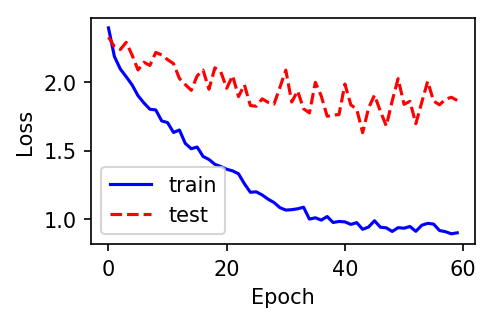

mem_rec/spk_rec data


<Figure size 432x288 with 0 Axes>

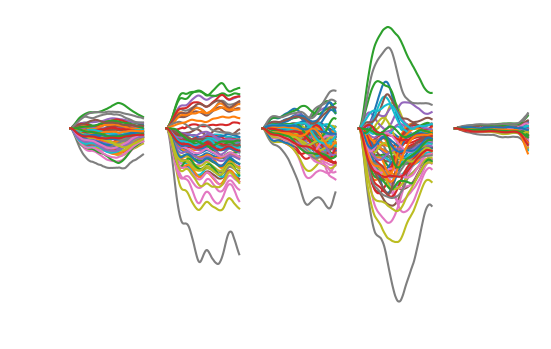

Output data


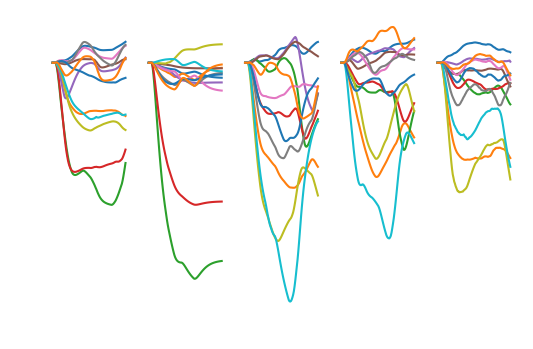

Spike Activity


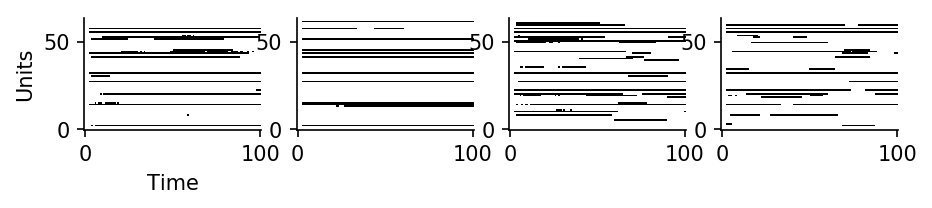

Train accuracy: 0.798939
Test accuracy: 0.531250


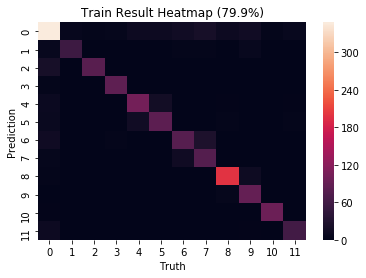

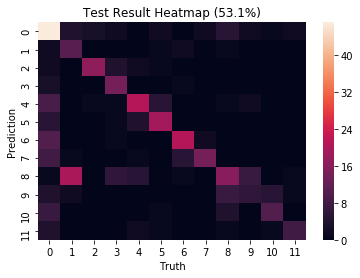

ℹ️ *Simple-SNN* Trail #5 finished.
[expecting to finish at 2020-01-27 18:50:58]
Epoch 1/10
  2.18%  [=>......................................................]   

-- canceled --


In [14]:
try:
    notify('*Simple-SNN* has started.', mark='info')
    for i in range(10):
        if should_init:
            init_network()
            should_init = False
        train(learning_rate=2e-4, nb_epochs=10)
        plot_loss_diagrams()
        plot_neuron_activities()
        print_and_plot_accuracy_metrics()
        notify('*Simple-SNN* Trail #%d finished.' % i, mark='info')
    notify('*Simple-SNN* finished!', mark='ok')
except KeyboardInterrupt:
    print '\n\n-- canceled --'
except:
    notify('*Simple-SNN* failed!', mark='error')
    raise